In [2]:
limit_rows   = 7000000
train_df = pd.read_csv("train_encoded.csv", nrows=limit_rows)

#reader = pd.read_csv('train_ver2.csv', chunksize=100000, header=0)
#train_df = pd.concat([chunk for chunk in reader])

unique_ids   = pd.Series(train_df["ncodpers"].unique())
limit_people = 1.2e4
unique_id    = unique_ids.sample(n=limit_people)
train_df     = train_df[train_df.ncodpers.isin(unique_id)]

C:\Users\prill\Anaconda2\lib\site-packages\pandas\core\generic.py:2569: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  locs = rs.choice(axis_length, size=n, replace=replace, p=weights)


In [53]:
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
plt.style.use('fivethirtyeight')
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import operator

In [3]:
train_df.head()

,ncodpers,ind_empleado,pais_residencia,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,...,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,fecha_dato_month,fecha_dato_year,month_int,fecha_alta_month,fecha_alta_year,fecha_alta_day,fecha_alta_month_int
33,1050603,0,0,1,23,0,35,1,1,1,...,0,0,0,1,0,1,8,-3,10,8
68,1050651,0,0,1,30,0,35,1,1,0,...,0,0,1,1,0,1,8,-3,10,8
155,1050875,0,0,0,22,0,35,1,1,0,...,0,0,0,1,0,1,8,-3,10,8
304,1050485,0,0,1,28,0,35,1,1,1,...,0,0,0,1,0,1,8,-3,10,8
350,1050285,0,0,0,23,0,35,1,1,1,...,0,0,0,1,0,1,8,-3,10,8


In [4]:
test_df = pd.read_csv("test_encoded.csv")
test_df.head()

,ncodpers,ind_empleado,pais_residencia,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,...,ind_actividad_cliente,renta,segmento,fecha_dato_month,fecha_dato_year,month_int,fecha_alta_month,fecha_alta_year,fecha_alta_day,fecha_alta_month_int
0,15889,3,0,0,56,0,256,1,1,0,...,1,326124.906250,1,6,1,18,1,-20,16,13
1,1170544,0,0,1,36,0,34,1,1,1,...,0,-2.000000,2,6,1,18,8,-2,28,20
2,1170545,0,0,0,22,0,34,1,1,0,...,1,-2.000000,3,6,1,18,8,-2,28,20
3,1170547,0,0,1,22,0,34,1,1,1,...,0,148402.984375,3,6,1,18,8,-2,28,20
4,1170548,0,0,1,22,0,34,1,1,1,...,0,106885.796875,3,6,1,18,8,-2,28,20


## 1. Data Cleaning

In [5]:
train_df.isin([-1]).any()

ncodpers                 False
ind_empleado              True
pais_residencia          False
sexo                      True
age                      False
ind_nuevo                 True
antiguedad                True
indrel                    True
indrel_1mes               True
tiprel_1mes               True
indresi                   True
indext                    True
conyuemp                  True
canal_entrada            False
indfall                   True
tipodom                   True
cod_prov                  True
ind_actividad_cliente     True
renta                     True
segmento                  True
ind_ahor_fin_ult1        False
ind_aval_fin_ult1        False
ind_cco_fin_ult1         False
ind_cder_fin_ult1        False
ind_cno_fin_ult1         False
ind_ctju_fin_ult1        False
ind_ctma_fin_ult1        False
ind_ctop_fin_ult1        False
ind_ctpp_fin_ult1        False
ind_deco_fin_ult1        False
ind_deme_fin_ult1        False
ind_dela_fin_ult1        False
ind_ecue

In [6]:
test_df.isin([-1]).any()

ncodpers                 False
ind_empleado             False
pais_residencia          False
sexo                      True
age                      False
ind_nuevo                False
antiguedad               False
indrel                   False
indrel_1mes               True
tiprel_1mes               True
indresi                  False
indext                   False
conyuemp                  True
canal_entrada            False
indfall                  False
tipodom                  False
cod_prov                  True
ind_actividad_cliente    False
renta                    False
segmento                  True
fecha_dato_month         False
fecha_dato_year          False
month_int                False
fecha_alta_month         False
fecha_alta_year           True
fecha_alta_day           False
fecha_alta_month_int     False
dtype: bool

### ind_actividad_cliente
Activity index (1, active customer; 0, inactive customer)  
should be conducted at the very fist step

In [7]:
train_df.ind_actividad_cliente.value_counts()

 0    47000
 1    45217
-1      390
Name: ind_actividad_cliente, dtype: int64

In [8]:
train_df.ind_actividad_cliente.isin([-1]).sum()

390

these entities should be excluded from the model.

In [9]:
train_df = train_df[train_df.ind_actividad_cliente != -1]
test_df = test_df[test_df.ind_actividad_cliente != -1]

### ind_nuevo
 which indicates whether a customer is new or not

In [10]:
train_df["ind_nuevo"].unique()

array([0, 1], dtype=int64)

In [11]:
train_df["ind_nuevo"].isin([-1]).sum()

0

Let's see if we can fill in missing values by looking how many months of history these customers have.

In [12]:
months_active = train_df.loc[train_df["ind_nuevo"].isin([-1]),:].groupby("ncodpers", sort=False).size()
months_active.max()

nan

Looks like these are all new customers, so replace accordingly.

In [13]:
train_df.ix[train_df["ind_nuevo"].isin([-1]),"ind_nuevo"] = 1

### antiguedad
Customer seniority (in months)

In [15]:
train_df["antiguedad"].isin([-1]).sum()

0

same as ind_nuevo. Let's see if those are same customers.

In [16]:
train_df.ix[train_df["antiguedad"].isin([-1]),"ind_nuevo"].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: ind_nuevo, dtype: float64

same customers. Let's give them minimum seniority.

In [17]:
train_df.ix[train_df["antiguedad"].isin([-1]),"antiguedad"] = train_df["antiguedad"].min()
train_df.ix[train_df["antiguedad"].isin([-2]),"antiguedad"] = train_df["antiguedad"].min()

### fetcha_alta
Same entries don't have the date they joined the company.
- missing values are converted as below when data are squeezed  
DF['fecha_alta'] = DF['fecha_alta'].map(lambda x: '2020-00-00' if x == -1 else x)  
DF['fecha_alta_month'] = DF['fecha_alta'].map(lambda x: int(x[5:7])).astype(np.int8)  
DF['fecha_alta_year'] = DF['fecha_alta'].map(lambda x: int(x[0:4]) - 2015).astype(np.int8)  
DF['fecha_alta_day'] = DF['fecha_alta'].map(lambda x: int(x[8:10])).astype(np.int8)  
DF['fecha_alta_motnh_int'] = (DF['fecha_alta_month'] + 12 * DF['fecha_dato_year']).astype(np.int8)


In [18]:
train_df["fecha_alta_month"].isin([00]).sum()

0

filling missing values with medians respectively.

In [19]:
# fecha_alta_month
monthes = train_df.ix[:,"fecha_alta_month"].sort_values().reset_index()
median_month = int(np.median(monthes))
train_df.ix[train_df.fecha_alta_month.isin([-1]), "fecha_alta_month"] = monthes.ix[median_month, "fecha_alta_month"]
# fecha_alta_day
days = train_df.ix[:,"fecha_alta_day"].sort_values().reset_index()
median_day = int(np.median(days))
train_df.ix[train_df.fecha_alta_day.isin([-1]), "fecha_alta_day"] = days.ix[median_day, "fecha_alta_day"]
# fecha_alta_year
years = train_df.ix[:,"fecha_alta_year"].sort_values().reset_index()
median_year = int(np.median(years))
train_df.ix[train_df.fecha_alta_year.isin([-1]), "fecha_alta_year"] = years.ix[median_year, "fecha_alta_year"]
# fecha_alta_month_int
month_int = train_df.ix[:,"fecha_alta_month_int"].sort_values().reset_index()
median_month_int = int(np.median(month_int))
train_df.ix[train_df.fecha_alta_month_int.isin([-1]), "fecha_alta_month_int"] = month_int.ix[median_month_int, "fecha_alta_month_int"]

### indrel
1 (First/Primary), 99 (Primary customer during the month but not at the end of the month)

In [20]:
train_df["indrel"].unique()

array([1, 2], dtype=int64)

In [21]:
train_df["indrel"].isin([-1]).sum()

0

In [22]:
train_df["indrel"].value_counts()

1    92240
2      157
Name: indrel, dtype: int64

filling with the most frequent values

In [23]:
train_df.ix[train_df.indrel.isin([-1]),"indrel"] = 1

### tipodom
Addres type. 1, primary address

In [24]:
train_df["tipodom"].value_counts()

1    92397
Name: tipodom, dtype: int64

doens't seem to be meaningful. so drop it.

In [25]:
train_df.drop(["tipodom"],axis=1,inplace=True)
test_df.drop(["tipodom"],axis=1,inplace=True)

### age

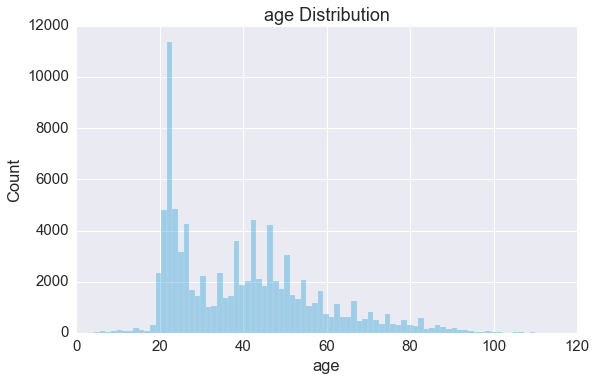

In [26]:
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style('darkgrid')
    sns.distplot(train_df["age"], bins=80, kde=False)
    sns.plt.title("age Distribution")
    plt.ylabel("Count")

In [27]:
train_df.ix[(train_df.age > -2)&(train_df.age < 18),"age"]  = train_df.ix[(train_df.age >= 18) & (train_df.age <= 30),"age"].mean()
train_df.ix[train_df.age > 100,"age"] = train_df.ix[(train_df.age >= 30) & (train_df.age <= 100),"age"].mean()
train_df.ix[train_df["age"]==-2,"age"] = train_df["age"].mean()
train_df["age"] = train_df["age"].astype(int)

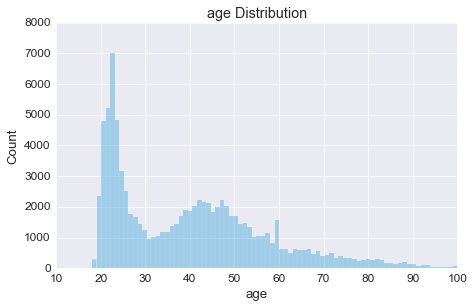

In [28]:
with sns.plotting_context("paper",font_scale=1.5):
    sns.set_style('darkgrid')
    sns.distplot(train_df["age"], bins=80, kde=False)
    sns.plt.title("age Distribution")
    plt.ylabel("Count")

### cod_prov
Province code (customer's address)

In [29]:
train_df.cod_prov.isin([-1]).sum()

486

In [30]:
test_df.cod_prov.isin([-1]).sum()

3996

In [31]:
train_df.ix[train_df.cod_prov.isin([-1]),"cod_prov"] = train_df.cod_prov.median()
test_df.ix[test_df.cod_prov.isin([-1]),"cod_prov"] = test_df.cod_prov.median()

### renta
: gross income

In [104]:
train_df.renta[train_df.renta==-1].count()

0

In [103]:
train_df.renta.isnull().sum()

14583

In [81]:
test_df.renta.isin([-1]).sum()

0

Here is a feature that is missing a lot of values. Filling missing values with a median might not be accurate.  
let's take a look at the median income by region

In [122]:
incomes = train_df.ix[train_df.renta!=(-1 or NAN),:].groupby("cod_prov").agg({"renta":{"MedianIncome":np.median}})
incomes.sort_values(by=("renta","MedianIncome"),inplace=True)
incomes.reset_index(inplace=True)
incomes.cod_prov = incomes.cod_prov.astype("category", categories=[i for i in train_df.cod_prov.unique()],ordered=False)
incomes.head()

,cod_prov,renta
,,MedianIncome
0,16.0,54864.898438
1,5.0,60015.089844
2,12.0,61734.121094
3,13.0,64370.519531
4,21.0,65118.660156


(40000, 180000)

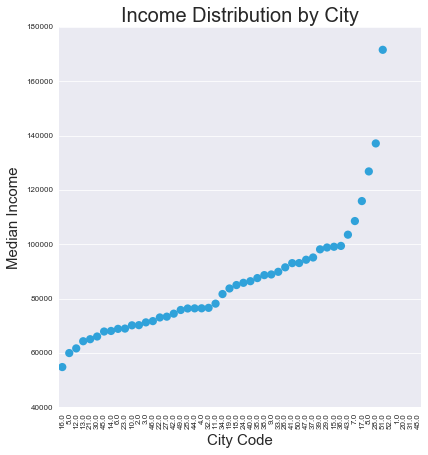

In [106]:
with sns.plotting_context("paper"):
    sns.set_style("darkgrid")
    sns.factorplot(x="cod_prov", y=("renta","MedianIncome"), data=incomes, size=6, linestyles="None", order=(i for i in incomes.cod_prov))

plt.title("Income Distribution by City",size=20)

plt.xticks(rotation=90)
plt.xlabel("City Code",size=15)

plt.ylabel("Median Income",size=15)
plt.ylim(40000,180000)

In [107]:
grouped = train_df.groupby("cod_prov").agg({"renta":lambda x: x.median()}).reset_index()
new_incomes = pd.merge(train_df,grouped,how="inner",on="cod_prov").ix[:, ["cod_prov","renta_y"]]
new_incomes = new_incomes.rename(columns={"renta_y":"renta"}).sort_values("renta").sort_values("cod_prov")
train_df.sort_values("cod_prov",inplace=True)
train_df = train_df.reset_index()
new_incomes = new_incomes.reset_index()

grouped2 = test_df.groupby("cod_prov").agg({"renta":lambda x: x.median()}).reset_index()
new_incomes2 = pd.merge(test_df,grouped,how="inner",on="cod_prov").ix[:, ["cod_prov","renta_y"]]
new_incomes2 = new_incomes2.rename(columns={"renta_y":"renta"}).sort_values("renta").sort_values("cod_prov")
test_df.sort_values("cod_prov",inplace=True)
test_df = test_df.reset_index()
new_incomes2 = new_incomes2.reset_index()

In [141]:
train_df.ix[train_df.renta.isin([-1]) + train_df.renta.isnull(),"renta"] \
= new_incomes.ix[train_df.renta.isin([-1]) + train_df.renta.isnull(),"renta"].reset_index()
train_df.ix[train_df.renta.isin([-1]) + train_df.renta.isnull(),"renta"] \
= train_df.ix[train_df.renta.isin([not -1]) + train_df.renta.notnull(),"renta"].median()

test_df.ix[test_df.renta.isin([-1]) + test_df.renta.isnull(),"renta"] \
= new_incomes2.ix[test_df.renta.isin([-1]) + test_df.renta.isnull(),"renta"].reset_index()
test_df.ix[test_df.renta.isin([-1]) + test_df.renta.isnull(),"renta"] \
= test_df.ix[test_df.renta.isin([not -1]) + test_df.renta.notnull(),"renta"].median()

In [142]:
train_df["renta"].isnull().sum()

0

In [143]:
train_df["renta"].isin([-1]).sum()

0

### left features
There are many categorical features left to be cleaned. First, let's take a look at them.

In [38]:
train_df.isin([-1]).any()

index                    False
ncodpers                 False
ind_empleado             False
pais_residencia          False
sexo                     False
age                      False
ind_nuevo                False
antiguedad               False
indrel                   False
indrel_1mes               True
tiprel_1mes               True
indresi                  False
indext                   False
conyuemp                  True
canal_entrada            False
indfall                  False
cod_prov                 False
ind_actividad_cliente    False
renta                    False
segmento                  True
ind_ahor_fin_ult1        False
ind_aval_fin_ult1        False
ind_cco_fin_ult1         False
ind_cder_fin_ult1        False
ind_cno_fin_ult1         False
ind_ctju_fin_ult1        False
ind_ctma_fin_ult1        False
ind_ctop_fin_ult1        False
ind_ctpp_fin_ult1        False
ind_deco_fin_ult1        False
ind_deme_fin_ult1        False
ind_dela_fin_ult1        False
ind_ecue

In [39]:
missing_features = ["indrel_1mes", "tiprel_1mes", "conyuemp", "segmento", "ind_nomina_ult1", "ind_nom_pens_ult1"]
for col in missing_features:
    print("Unique values for {0}:\n{1}\n".format(col,train_df[col].unique()))

Unique values for indrel_1mes:
[ 1 -1 -2  3  4  2]

Unique values for tiprel_1mes:
[ 0  1 -1  4  2]

Unique values for conyuemp:
[-1  0]

Unique values for segmento:
[ 2  3  1 -1]

Unique values for ind_nomina_ult1:
[ 1  0 -1]

Unique values for ind_nom_pens_ult1:
[ 1  0 -1]



conyuemp has one type of values to drop it.

In [40]:
train_df.drop(["conyuemp"], axis=1, inplace=True)
test_df.drop(["conyuemp"], axis=1, inplace=True)

### indrel_1mes

In [41]:
train_df["indrel_1mes"].value_counts()

 1    91292
-1     1069
 3       18
 2        8
-2        6
 4        4
Name: indrel_1mes, dtype: int64

In [42]:
test_df["indrel_1mes"].value_counts()

 1    929565
 3        27
-1        23
Name: indrel_1mes, dtype: int64

filling missing values with the most frequent value, which is 1.

In [43]:
train_df.ix[train_df.indrel_1mes.isin([-1]), "indrel_1mes"] = 1
test_df.ix[test_df.indrel_1mes.isin([-1]), "indrel_1mes"] = 1

### tiprel_1mes
Customer relation type at the beginning of the month, 0 (active), 1 (inactive), 2 (former customer), 4 (Potential)

In [44]:
train_df["tiprel_1mes"].value_counts()

 1    47128
 0    44172
-1     1069
 2       22
 4        6
Name: tiprel_1mes, dtype: int64

In [45]:
test_df['tiprel_1mes'].value_counts()

 1    535943
 0    393622
 2        27
-1        23
Name: tiprel_1mes, dtype: int64

In [46]:
train_df.ix[train_df.tiprel_1mes.isin([-1]), "tiprel_1mes"] = 0
test_df.ix[test_df.tiprel_1mes.isin([-1]), "tiprel_1mes"] = 0

### segmento
segmentation: 01 - VIP, 02 - Individuals 03 - college graduated

In [47]:
train_df["segmento"].value_counts()

 2    53313
 3    33819
 1     3991
-1     1274
Name: segmento, dtype: int64

In [48]:
test_df["segmento"].value_counts()

 2    545378
 3    346028
 1     35961
-1      2248
Name: segmento, dtype: int64

In [49]:
train_df.ix[train_df.segmento.isin([-1]), "segmento"] = 2
test_df.ix[test_df.segmento.isin([-1]), "segmento"] = 2

### ind_nomina_ult1, ind_nom_pens_ult1

In [50]:
train_df["ind_nomina_ult1"].value_counts()

 0    86976
 1     5420
-1        1
Name: ind_nomina_ult1, dtype: int64

In [51]:
train_df["ind_nom_pens_ult1"].value_counts()

 0    86518
 1     5878
-1        1
Name: ind_nom_pens_ult1, dtype: int64

The numer of missing values is very small. just replace them with the most common value.

In [52]:
train_df.ix[train_df.ind_nomina_ult1.isin([-1]), "ind_nomina_ult1"] = 0
train_df.ix[train_df.ind_nom_pens_ult1.isin([-1]), "ind_nom_pens_ult1"] = 0

In [53]:
train_df.isin([-1]).any().sum()

0

In [144]:
train_df.isnull().any()

level_0                  False
index                    False
ncodpers                 False
ind_empleado             False
pais_residencia          False
sexo                     False
age                      False
ind_nuevo                False
antiguedad               False
indrel                   False
indrel_1mes              False
tiprel_1mes              False
indresi                  False
indext                   False
canal_entrada            False
indfall                  False
cod_prov                 False
ind_actividad_cliente    False
renta                    False
segmento                 False
ind_ahor_fin_ult1        False
ind_aval_fin_ult1        False
ind_cco_fin_ult1         False
ind_cder_fin_ult1        False
ind_cno_fin_ult1         False
ind_ctju_fin_ult1        False
ind_ctma_fin_ult1        False
ind_ctop_fin_ult1        False
ind_ctpp_fin_ult1        False
ind_deco_fin_ult1        False
ind_deme_fin_ult1        False
ind_dela_fin_ult1        False
ind_ecue

### sexo

In [54]:
train_df["sexo"].value_counts()

0    49654
1    42743
Name: sexo, dtype: int64

In [55]:
test_df["sexo"].value_counts()

 0    504515
 1    425095
-1         5
Name: sexo, dtype: int64

In [56]:
train_df.ix[train_df.sexo.isin([-1]), "sexo"] = 0
test_df.ix[test_df.sexo.isin([-1]), "sexo"] = 0

double check if there any missing values

## 2. Random Forest

In [54]:
target_cols = ['ncodpers', 'ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 'ind_cco_fin_ult1',
               'ind_cder_fin_ult1', 'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
               'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1', 'ind_ctpp_fin_ult1',
               'ind_deco_fin_ult1', 'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
               'ind_ecue_fin_ult1', 'ind_fond_fin_ult1', 'ind_hip_fin_ult1',
               'ind_plan_fin_ult1', 'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
               'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1', 'ind_viv_fin_ult1',
               'ind_nomina_ult1', 'ind_nom_pens_ult1', 'ind_recibo_ult1']

feature_cols = ["ind_empleado","pais_residencia","sexo", "age", "ind_nuevo", "antiguedad",
                "indrel","indrel_1mes","tiprel_1mes","indresi","indext","canal_entrada","indfall","cod_prov","ind_actividad_cliente",
                "renta","segmento","fecha_dato_month","fecha_dato_year","month_int","fecha_alta_month","fecha_alta_year","fecha_alta_day",
                "fecha_alta_month_int"]

I got warning message when fitting data into Random Forest.(Input contains NaN, infinity or a value too large for dtype('float32').)
I look into data's info as below.

In [59]:
train_df.describe()

,ncodpers,ind_empleado,pais_residencia,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,...,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,fecha_dato_month,fecha_dato_year,month_int,fecha_alta_month,fecha_alta_year,fecha_alta_day,fecha_alta_month_int
count,9.221700e+04,92217.000000,92217.000000,92217.000000,92217.000000,92217.000000,92217.000000,92217.000000,92217.000000,92217.000000,...,92217.000000,92217.000000,92217.000000,92217.000000,92217.0,92217.000000,92217.000000,92217.000000,92217.000000,92217.000000
mean,8.054349e+05,0.001822,0.130128,0.448995,40.313868,0.041478,80.197122,1.001670,0.978030,0.498064,...,0.059956,0.065617,0.137903,5.792403,0.0,5.792403,7.454515,-6.770053,15.984743,7.454515
std,4.219618e+05,0.067140,2.327721,0.497394,17.250691,0.199395,66.525189,0.040831,0.215323,0.523706,...,0.237499,0.247700,0.344800,2.851980,0.0,2.851980,3.288306,5.508675,8.942256,3.288306
min,1.588900e+04,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,-2.000000,-1.000000,...,-1.000000,-1.000000,0.000000,1.000000,0.0,1.000000,1.000000,-20.000000,1.000000,1.000000
25%,4.224790e+05,0.000000,0.000000,0.000000,24.000000,0.000000,23.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,3.000000,0.0,3.000000,5.000000,-12.000000,8.000000,5.000000
50%,9.225610e+05,0.000000,0.000000,0.000000,39.000000,0.000000,47.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,6.000000,0.0,6.000000,8.000000,-4.000000,16.000000,8.000000
75%,1.169356e+06,0.000000,0.000000,1.000000,51.000000,0.000000,139.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,8.000000,0.0,8.000000,10.000000,-2.000000,24.000000,10.000000
max,1.495120e+06,3.000000,77.000000,1.000000,111.000000,1.000000,249.000000,2.000000,4.000000,4.000000,...,1.000000,1.000000,1.000000,10.000000,0.0,10.000000,12.000000,0.000000,31.000000,12.000000


In [73]:
train_df.ix[:,'tiprel_1mes':'ind_nomina_ult1'].describe()

,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,ind_actividad_cliente,renta,...,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1
count,92217.000000,92217.000000,92217.000000,92217.000000,92217.000000,92217.000000,92217.0,92217.000000,92217.000000,9.221700e+04,...,92217.000000,92217.000000,92217.000000,92217.000000,92217.000000,92217.000000,92217.000000,92217.000000,92217.000000,92217.000000
mean,0.498064,0.994621,0.048288,-0.999772,9.500298,0.001963,1.0,26.675309,0.490333,1.083746e+05,...,0.089474,0.024106,0.007623,0.009738,0.002776,0.056703,0.052442,0.028867,0.004056,0.059956
std,0.523706,0.073142,0.214376,0.015089,22.783825,0.044260,0.0,12.876087,0.499909,1.226320e+05,...,0.285428,0.153380,0.086979,0.098200,0.052615,0.231276,0.222917,0.167433,0.063555,0.237499
min,-1.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,1.0,-1.000000,0.000000,-1.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,1.000000,0.000000,-1.000000,1.000000,0.000000,1.0,15.000000,0.000000,4.661600e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,-1.000000,4.000000,0.000000,1.0,28.000000,0.000000,8.676300e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,-1.000000,5.000000,0.000000,1.0,35.000000,1.000000,1.398980e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.000000,1.000000,1.000000,0.000000,160.000000,1.000000,1.0,52.000000,1.000000,3.227687e+06,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [74]:
train_df.ix[:,'renta':'ind_ecue_fin_ult1'].describe()

,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1
count,9.221700e+04,92217.000000,92217.0,92217.000000,92217.000000,92217.000000,92217.000000,92217.000000,92217.000000,92217.000000,92217.000000,92217.000000,92217.000000,92217.000000,92217.000000
mean,1.083746e+05,2.270764,0.0,0.000206,0.704035,0.000358,0.085483,0.009890,0.009402,0.146849,0.047583,0.003232,0.002093,0.047909,0.089474
std,1.226320e+05,0.674264,0.0,0.014353,0.456478,0.018914,0.279601,0.098955,0.096506,0.353958,0.212884,0.056755,0.045700,0.213574,0.285428
min,-1.000000e+00,-1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.661600e+04,2.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,8.676300e+04,2.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.398980e+05,3.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.227687e+06,3.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


resize data

In [106]:
def resize_data(DF,is_DF):
    DF['ncodpers'] = DF['ncodpers'].astype(np.int32)
    DF['renta'] = DF['renta'].astype(np.float32)
    DF['indrel'] = DF['indrel'].astype(np.int8)
    DF['ind_empleado'] = DF['ind_empleado'].astype(np.int8)
    DF['sexo'] = DF['sexo'].astype(np.int8)
    DF['age'] = DF['age'].astype(np.int16)
    DF['ind_nuevo'] = DF['ind_nuevo'].astype(np.int8)
    DF['antiguedad'] = DF['antiguedad'].astype(int)
    DF['antiguedad'] = DF['antiguedad'].astype(np.int16)
    DF['indrel_1mes'] = DF['indrel_1mes'].astype(np.float16)
    DF['indrel_1mes'] = DF['indrel_1mes'].astype(np.int8)
    DF['tiprel_1mes'] = DF['tiprel_1mes'].astype(np.int8)
    DF['indresi'] = DF['indresi'].astype(np.int8)
    DF['indext'] = DF['indext'].astype(np.int8)
    DF['conyuemp'] = DF['conyuemp'].astype(np.int8)
    DF['canal_entrada'] = DF['canal_entrada'].astype(np.int16)
    DF['indfall'] = DF['indfall'].astype(np.int8)
    DF['pais_residencia'] = DF['pais_residencia'].astype(np.int8)
    DF['tipodom'] = DF['tipodom'].astype(np.int8)
    DF['cod_prov'] = DF['cod_prov'].astype(np.int8)
    DF['ind_actividad_cliente'].astype(np.int8)
    DF['fecha_dato_month'] = DF['fecha_dato_month'].astype(np.int8)
    DF['fecha_dato_year'] = DF['fecha_dato_year'].astype(np.int8)
    DF['month_int'] = DF['month_int'].astype(np.int8)

    DF['fecha_alta_month'] = DF['fecha_alta_month'].astype(np.int8)
    DF['fecha_alta_year'] = DF['fecha_alta_year'].astype(np.int8)
    DF['fecha_alta_day'] = DF['fecha_alta_day'].astype(np.int8)
    DF['fecha_alta_month_int'] = DF['fecha_alta_month_int'].astype(np.int8)

    DF['segmento'] = DF['segmento'].astype(np.int8)

    for col in target_cols:
        if is_DF:
            DF[col] = DF[col].astype(np.int8)

    return DF

resize_data(train_df, True)
resize_data(test_df, False)

,ncodpers,ind_empleado,pais_residencia,sexo,age,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,...,ind_actividad_cliente,renta,segmento,fecha_dato_month,fecha_dato_year,month_int,fecha_alta_month,fecha_alta_year,fecha_alta_day,fecha_alta_month_int
0,17,3,0,0,56,0,256,1,1,0,...,1,326124.906250,1,6,1,18,1,-20,16,13
1,112,0,0,1,36,0,34,1,1,1,...,0,-2.000000,2,6,1,18,8,-2,28,20
2,113,0,0,0,22,0,34,1,1,0,...,1,-2.000000,3,6,1,18,8,-2,28,20
3,115,0,0,1,22,0,34,1,1,1,...,0,148402.984375,3,6,1,18,8,-2,28,20
4,116,0,0,1,22,0,34,1,1,1,...,0,106885.796875,3,6,1,18,8,-2,28,20
5,118,0,0,0,22,0,34,1,1,1,...,0,-2.000000,3,6,1,18,8,-2,28,20
6,120,0,0,1,51,0,34,1,1,0,...,1,96395.882812,2,6,1,18,8,-2,28,20
7,121,0,0,1,22,0,34,1,1,1,...,0,-2.000000,3,6,1,18,8,-2,28,20
8,123,0,0,0,22,0,34,1,1,1,...,0,-2.000000,3,6,1,18,8,-2,28,20
9,125,0,0,1,22,0,34,1,1,0,...,1,68322.718750,3,6,1,18,8,-2,28,20


In [79]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92217 entries, 33 to 6999931
Data columns (total 51 columns):
ncodpers                 92217 non-null int8
ind_empleado             92217 non-null int8
pais_residencia          92217 non-null int8
sexo                     92217 non-null int8
age                      92217 non-null int16
ind_nuevo                92217 non-null int8
antiguedad               92217 non-null int16
indrel                   92217 non-null int8
indrel_1mes              92217 non-null int8
tiprel_1mes              92217 non-null int8
indresi                  92217 non-null int8
indext                   92217 non-null int8
conyuemp                 92217 non-null int8
canal_entrada            92217 non-null int16
indfall                  92217 non-null int8
tipodom                  92217 non-null int8
cod_prov                 92217 non-null int8
ind_actividad_cliente    92217 non-null int32
renta                    92217 non-null float32
segmento                 9

devide train data set into y_train and x_train.

In [104]:
y_train = DataFrame(data=train_df, columns = target_cols)
x_train = DataFrame(data=train_df, columns = feature_cols)
x_test = DataFrame(data=test_df, columns = feature_cols)
print(y_train.shape, x_train.shape, x_test.shape)

((92217, 25), (92217, 24), (929615, 24))


In [100]:
# running model
clf = RandomForestClassifier(n_estimators=10,
                             max_depth=10,
                             n_jobs=1,
                             random_state=42)
clf.fit(x_train,y_train)
del x_train
del y_train

In [112]:
# predicting
bar = x_test.shape[0] / 10

for i in xrange(10):
    start = bar*(i+1)
    end = 
    y_pred = np.array(clf.predict_proba(x_test))[:,:,1].T
del x_test

MemoryError: 

## 3. Feature Selection

In [43]:
X = x_train.values
test = SelectKBest(score_func=f_regression)
prod_cols = list(y_train.columns)

In [44]:
d = {}
for p in prod_cols:
    y = np.array(train_df[p])
    fit = test.fit(X, y)
    l = zip(x_train.columns, np.around(fit.scores_))
    d[p] = sorted(l, key=lambda x: x[1], reverse=True)

In [45]:
ranking = pd.DataFrame(index=x_train.columns,columns=prod_cols)

In [46]:
for p in prod_cols:
    i = 0
    for r in d[p]:
        ranking[p][r[0]] = i
        i += 1

In [49]:
ranking['total'] = ranking.sum(axis=1)

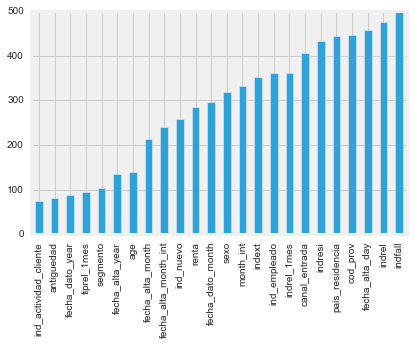

In [50]:
ranking.sort_values('total')
ranking.sort_values('total')['total'].plot(kind='bar')